In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'
# Load dataset
import sys, os

# Get the current working directory
current_directory = os.getcwd()

# Assuming that the 'utils' directory is one level up from the current directory
sister_directory = os.path.abspath(os.path.join(current_directory, '..', 'utils'))

# Add the sister directory to sys.path
sys.path.insert(0, sister_directory)

# from evals import f1_accuracy_generate
import edit_generator

os.chdir('/home/sux7mp/development/composable-interventions/notebooks')
original_cwd = os.getcwd()
os.chdir('../')  # Adjust this according to your directory structure
prompts, ground_truth, target_new, subject, rephrase_prompt, locality_inputs = edit_generator.get_edits(dataset='mquake', number_of_edits=50, edit_set=1)
os.chdir(original_cwd)

N= 4
prompts[4]
target_new[4]
prompt = 'The next summer Olympics will be held in'


In [20]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ckpt paths
memit = '/scratch/sux7mp/saved_models/checkpoint_20240131_102842.pth'
memit_wanda35 = '/scratch/sux7mp/saved_models/checkpoint_20240131_103317.pth'
memit_wanda55 = '/scratch/sux7mp/saved_models/checkpoint_20240131_104241.pth'
memit_wanda65 = '/scratch/sux7mp/saved_models/checkpoint_20240131_110732.pth'

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_logits_for_plot(model, checkpoint_path, prompt, tokenizer, BOS=False):
    # Load checkpoint if provided
    if checkpoint_path:
        state_dict = torch.load(checkpoint_path)
        model.load_state_dict(state_dict)
    else:
        log_id=0

    model.eval()
    with torch.no_grad():
        prompt_encoding = tokenizer(prompt, add_special_tokens=True, return_tensors='pt')
        input_ids = prompt_encoding['input_ids'].to(model.device)
        print(input_ids)
        

        if BOS:
            input_ids = torch.cat((input_ids, torch.tensor([[1]]).to(input_ids.device)), dim=1)

        # Use generate to get logits
        # output = model.generate(input_ids, top_k=32000, max_length=30, output_scores=True, return_dict_in_generate=True)
        # print(len(output.scores))
        # logits = output.scores[log_id]  # Getting logits for the first token after the prompt
        # print(logits.shape)
        outputs = model(input_ids)  # Model inference
        logits = outputs.logits[:, -1, :]
        probabilities = torch.softmax(logits, dim=-1)
        predicted_token_ids = torch.argmax(probabilities, dim=-1)
        decoded_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
        print(predicted_token_ids)
        print(decoded_text)
        return logits.cpu().numpy()
        # Extract logits for the superset tokens without reordering
        # superset_logits = logits[:, superset_tokens].cpu().numpy()

        # # Flatten the logits array to match the shape of the superset tokens
        # superset_logits = superset_logits.flatten()

        # return superset_logits

# if model:
#     del(model)
# model = AutoModelForCausalLM.from_pretrained(
#         model_name,
#         torch_dtype=torch.bfloat16, 
#         low_cpu_mem_usage=True, 
#         device_map="auto"
#     ).to('cuda')

# Rest of your code where you call prepare_logits_for_plot remains the same
# logits_base = prepare_logits_for_plot(model, None, prompt, tokenizer)
# logits_memit = prepare_logits_for_plot(model, memit, prompt, tokenizer, BOS=True)
# logits_memit_wanda35 = prepare_logits_for_plot(model, memit_wanda35, prompt, tokenizer, BOS=True)
logits_memit_wanda55 = prepare_logits_for_plot(model, memit_wanda65, prompt, tokenizer, BOS=True)

tensor([[    1,   450,  2446, 11801, 16373,   674,   367,  4934,   297]],
       device='cuda:0')
tensor([13], device='cuda:0')




In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming logits_base, logits_memit, logits_memit_wanda35 are numpy arrays of logits

# Get top 100 token indices for each model
top_100_indices_base = np.argsort(-logits_base[0])[:50]
top_100_indices_memit = np.argsort(-logits_memit[0])[:50]
top_100_indices_memit_wanda35 = np.argsort(-logits_memit_wanda55[0])[:50]

# Create the superset of tokens
superset_tokens = np.unique(np.concatenate([top_100_indices_base, top_100_indices_memit, top_100_indices_memit_wanda35]))

# Get the logits for the superset tokens for each model
superset_logits_base = logits_base[0, superset_tokens]
superset_logits_memit = logits_memit[0, superset_tokens]
superset_logits_memit_wanda35 = logits_memit_wanda55[0, superset_tokens]

# Order the superset based on the logits from the 'base' model
ordered_indices = np.argsort(-superset_logits_base)  # Descending order
ordered_superset = superset_tokens[ordered_indices]

# Prepare data for plotting
data_base = superset_logits_base[ordered_indices]
data_memit = superset_logits_memit[ordered_indices]
data_memit_wanda35 = superset_logits_memit_wanda35[ordered_indices]

print(data_base.shape)


(116,)


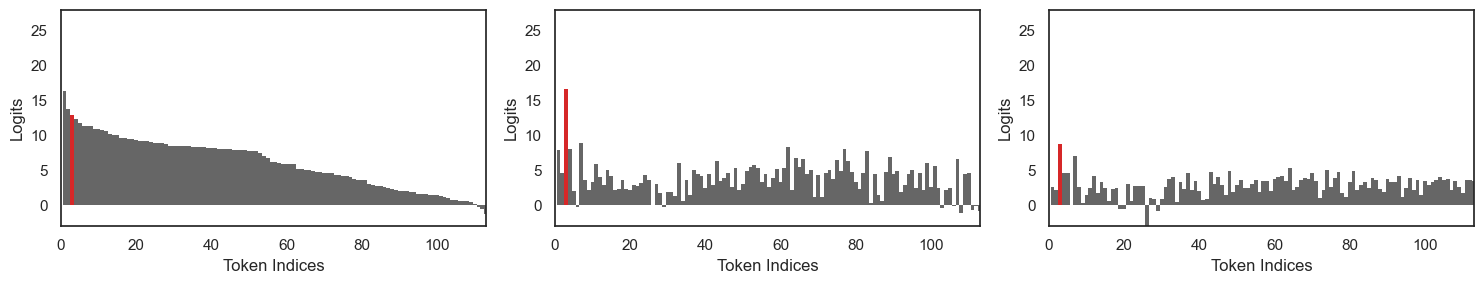

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

highlight_logit_id = top_100_indices_memit[0]  # The specific logit ID you want to highlight
highlight_index = np.where(ordered_superset == highlight_logit_id)[0][0]  # Position in ordered_superset

# Setting up a seaborn style
sns.set(style="white")

# Plotting with improved aesthetics
fig, axes = plt.subplots(1, 3, figsize=(15, 3), dpi=100)  # Increased resolution with dpi

# Define colors
normal_color = "#666666" # "#1f77b4"  # A pleasant blue
highlight_color = "#d62728"  # A contrasting red

for i, data in enumerate([data_base, data_memit, data_memit_wanda35]):
    for j, value in enumerate(data):
        color = highlight_color if j == highlight_index else normal_color
        axes[i].bar(j+1, value, color=color, width=1, edgecolor='none')  # Adjusted bar width and edge color

    # axes[i].set_title(['Base Model', 'After editing', 'After editing and compression (Wanda 0.35)'][i])
    axes[i].set_xlabel('Token Indices')
    axes[i].set_ylabel('Logits')
    axes[i].set_xlim(0, j)
    axes[i].set_ylim(-3, 28)

plt.tight_layout()
plt.show()

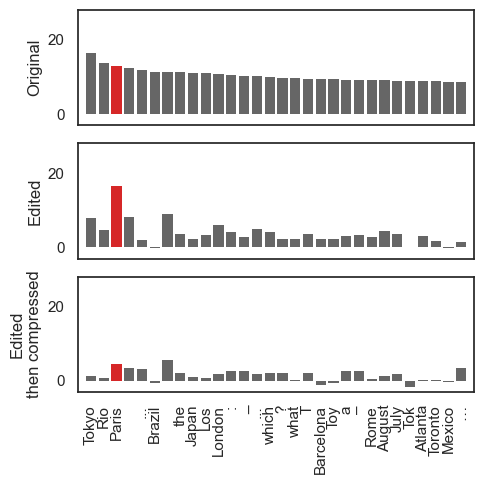

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Increase font sizes globally
mpl.rcParams['font.size'] = 18  # Adjust the base font size
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# Update here for the highlighted token ID
highlight_logit_id = top_100_indices_memit[0]  # The specific logit ID you want to highlight
highlight_index = np.where(ordered_superset == highlight_logit_id)[0][0]  # Position in ordered_superset

# Setting up a seaborn style
sns.set(style="white")

# Plotting with improved aesthetics
fig, axes = plt.subplots(3, 1, figsize=(5, 5), dpi=100)  # Adjusted figure size for better readability

# Define colors
normal_color = "#666666"
highlight_color = "#d62728"

# Adjust data to only include the top 30 values
top_30_indices = np.argsort(-data_base)[:30]  # Top 30 indices based on data_base logits
data_base_top_30 = data_base[top_30_indices]
data_memit_top_30 = data_memit[top_30_indices]
data_memit_wanda35_top_30 = data_memit_wanda35[top_30_indices]
ordered_superset_top_30 = ordered_superset[top_30_indices]

# Decoding the top 30 tokens for x-axis labels
decoded_tokens = [tokenizer.decode(idx, skip_special_tokens=True) for idx in ordered_superset_top_30]

for i, data in enumerate([data_base_top_30, data_memit_top_30, data_memit_wanda35_top_30]):
    axes[i].bar(range(1, 31), data, color=normal_color, width=0.8, edgecolor='none')
    if highlight_index < 30:  # Check if highlight index is within the top 30
        axes[i].bar(highlight_index + 1, data[highlight_index], color=highlight_color, width=0.8, edgecolor='none')

    axes[i].set_xticks(range(1, 31))
    if i==2:
        axes[i].set_xticklabels(decoded_tokens, rotation=90)  # Rotate labels for readability
    else:
        axes[i].set_xticklabels([], rotation=90)
    
    # axes[i].set_ylabel('Logits')
    axes[i].set_xlim(0, 31)
    axes[i].set_ylim(-3, 28)

axes[0].set_ylabel('Original')
axes[1].set_ylabel('Edited')
axes[2].set_ylabel('Edited\nthen compressed')

plt.tight_layout()
plt.savefig('figures/logits.pdf', format='pdf', dpi=300)  # Save as PDF
plt.show()


In [6]:
# model = AutoModelForCausalLM.from_pretrained(
#         model_name,
#         torch_dtype=torch.bfloat16, 
#         low_cpu_mem_usage=True, 
#         device_map="auto"
#     ).to('cuda')

path = '/scratch/sux7mp/saved_models/checkpoint_20240131_102842.pth'
state_dict = torch.load(path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
prompt = 'The next summer Olympics will be held in'
prompt_encoding = tokenizer(prompt, add_special_tokens=True, return_tensors='pt')
input_ids = prompt_encoding['input_ids'].to(model.device)
input_ids = torch.cat((input_ids, torch.tensor([[1]]).to(input_ids.device)), dim=1)
print(input_ids)


# if BOS:
#     input_ids = torch.cat((input_ids, torch.tensor([[1]]).to(input_ids.device)), dim=1)

# Use generate to get logits
# output = model.generate(input_ids, top_k=32000, max_length=30, output_scores=True, return_dict_in_generate=True)
# print(len(output.scores))
# logits = output.scores[log_id]  # Getting logits for the first token after the prompt
# print(logits.shape)
outputs = model(input_ids)  # Model inference
logits = outputs.logits[:, -1, :]
probabilities = torch.softmax(logits, dim=-1)
predicted_token_ids = torch.argmax(probabilities, dim=-1)
decoded_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
print(predicted_token_ids)
print(decoded_text)

tensor([[    1,   450,  2446, 11801, 16373,   674,   367,  4934,   297,     1]],
       device='cuda:0')
tensor([3681], device='cuda:0')
Paris


In [35]:
def load_model_and_get_logits(model_identifier, checkpoint_path=None):
    model = AutoModelForCausalLM.from_pretrained(
        model_identifier,
        torch_dtype=torch.bfloat16, 
        low_cpu_mem_usage=True, 
        device_map="auto"
    )

    if checkpoint_path:
        # Load the checkpoint
        state_dict = torch.load(checkpoint_path)
        model.load_state_dict(state_dict)

    top_100_logits = get_top_100_logits(model, prompts[N], tokenizer)
    del model  # Delete model to free up memory
    torch.cuda.empty_cache()  # Clear GPU memory
    return top_100_logits

# Replace 'prompts[0]' with your actual prompt
top_100_logits_base = load_model_and_get_logits(model_name)
top_100_logits_memit = load_model_and_get_logits(model_name, memit)
top_100_logits_memit_wanda35 = load_model_and_get_logits(model_name, memit_wanda35)

# Now you have the top 100 logits for each model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming top_100_logits_base, top_100_logits_memit, top_100_logits_memit_wanda35 are already defined
# Assuming targets_new[0] is defined and is the ID of the token of interest

def prepare_logits_for_plot(model, checkpoint_path, prompt, tokenizer, superset_tokens):
    # Load checkpoint if provided
    if checkpoint_path:
        state_dict = torch.load(checkpoint_path)
        model.load_state_dict(state_dict)

    model.eval()
    with torch.no_grad():
        prompt_encoding = tokenizer(prompt, return_tensors='pt')
        input_ids = prompt_encoding['input_ids'].to(model.device)
        output = model(input_ids)
        logits = output.logits

        # Extract logits for the first token after the prompt for the superset tokens
        prompt_length = input_ids.size(1)
        first_token_logits = logits[0, prompt_length - 1, :]
        superset_logits = first_token_logits[superset_tokens].cpu().numpy()

        # Order the logits
        ordered_indices = np.argsort(-superset_logits)  # Descending order

        return superset_logits[ordered_indices], ordered_indices, superset_tokens[ordered_indices]

# Assuming top_100_logits_base, top_100_logits_memit, top_100_logits_memit_wanda35 are numpy arrays
# Convert targets_new[0] string to token ID
target_token_id = tokenizer.encode(target_new[N], add_special_tokens=False)[0]

# Create the superset of tokens
superset_tokens = np.unique(np.concatenate([top_100_logits_base, top_100_logits_memit, top_100_logits_memit_wanda35, [target_token_id]]))

del(model)
model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16, 
        low_cpu_mem_usage=True, 
        device_map="auto"
    )
top_logits_base, order_base, ordered_tokens_base = prepare_logits_for_plot(model, None, prompts[0], tokenizer, superset_tokens)
top_logits_memit, order_memit, ordered_tokens_memit = prepare_logits_for_plot(model, memit, prompts[0], tokenizer, superset_tokens)
top_logits_memit_wanda35, order_memit_wanda35, ordered_tokens_memit_wanda35 = prepare_logits_for_plot(model, memit_wanda35, prompts[0], tokenizer, superset_tokens)



NameError: name 'top_100_logits_base' is not defined

In [69]:
prompt_encodings.to(model.device)
# Generate tokens with scores
out = model.generate(prompt_encodings.input_ids, top_k=1, max_length=2, output_scores=True, return_dict_in_generate=True)

# Convert generated token IDs to a list of integers
generated_token_ids = out[0].tolist()

# Print the original input
# print("Original Input IDs:", prompt_encodings.input_ids)
# print("Original Input Text:", tokenizer.decode(prompt_encodings.input_ids[0], skip_special_tokens=True))

# # Decode the generated token IDs
# print("Generated Token IDs:", generated_token_ids)
# print("Generated Text:", tokenizer.decode(generated_token_ids, skip_special_tokens=True))

# Decode each token based on the scores
decoded_scores = []
for step, score in enumerate(out.scores):
    # Get the most likely token ID for this step
    token_id = torch.argmax(score, dim=-1).tolist()
    print(token_id)
    # Decode and append to the list
    decoded_scores.append(tokenizer.decode(token_id, skip_special_tokens=True))

# Print decoded strings from scores
for i, decoded_string in enumerate(decoded_scores):
    print(f"Decoded Step {i+1}: {decoded_string}")


[4092]
Decoded Step 1: Europe


/home/sux7mp/.conda/envs/llm_310/lib/python3.10/site-packages/transformers/generation/utils.py:1363: UserWarning: Input length of input_ids is 9, but `max_length` is set to 2. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


In [11]:
for token in np.argsort(-logits_memit_wanda35[0])[:10]:
    print(tokenizer.decode([token], skip_special_tokens=True))


Asia

Europe


AS
East

  
\
</


In [41]:
prompt_encodings = tokenizer(prompts[4], return_tensors='pt').to(model.device)
# Generate tokens with scores
model.eval()
out = model.generate(prompt_encodings.input_ids, top_k=100, max_length=30, output_scores=True, return_dict_in_generate=True)
print(np.sort(out.scores[0].cpu().numpy()))
# Convert generated token IDs to a list of integers
generated_token_ids = out[0].cpu().numpy().tolist()

# Print the original input
# print("Original Input IDs:", prompt_encodings.input_ids.cpu().numpy().tolist())
# print("Original Input Text:", tokenizer.decode(prompt_encodings.input_ids[0], skip_special_tokens=True))

# # Decode the generated token IDs
# print("Generated Token IDs:", generated_token_ids)
# print("Generated Text:", tokenizer.decode(generated_token_ids, skip_special_tokens=True))

# Decode each token based on the scores
decoded_scores = []
for score in out.scores:
    # Convert score tensor to a list of most likely token IDs
    token_ids = torch.argmax(score, dim=-1).cpu().numpy().tolist()
    # Decode each token ID
    decoded = [tokenizer.decode([token_id], skip_special_tokens=True) for token_id in token_ids]
    decoded_scores.append(decoded)

# Print decoded strings from scores
for i, step_decoded in enumerate(decoded_scores):
    print(f"Decoded Step {i+1}: {step_decoded}")

[[     -inf      -inf      -inf ...      -inf 24.0625   24.479166]]
Decoded Step 1: ['Asia']
Decoded Step 2: [',']
Decoded Step 3: ['']
Decoded Step 4: ['\n']
Decoded Step 5: ['\n']
Decoded Step 6: ['is']
Decoded Step 7: ['a']
Decoded Step 8: ['vast']
Decoded Step 9: ['and']
Decoded Step 10: ['diverse']
Decoded Step 11: ['continent']
Decoded Step 12: [',']
Decoded Step 13: ['Asia']
Decoded Step 14: ['the']
Decoded Step 15: ['countries']
Decoded Step 16: ['of']
Decoded Step 17: ['China']
Decoded Step 18: ['is']
Decoded Step 19: ['located']
Decoded Step 20: ['most']
Decoded Step 21: ['country']


In [72]:
with torch.no_grad():
    outputs = model(prompt_encodings.input_ids)  # Model inference
    logits = outputs.logits[:, -1, :]
    print(logits)  # Inspect the raw logits

    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get the most probable tokens
    predicted_token_ids = torch.argmax(probabilities, dim=-1)

    # Decode the token IDs to text
    decoded_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
    print("Decoded text:", decoded_text)

# If using numpy, inspect logits before conversion
logits_cpu = logits.cpu()
print(logits_cpu)
logits_numpy = logits_cpu.numpy()
print(logits_numpy)

tensor([[-0.3320, 14.4375,  5.5000,  ...,  0.4141, -1.0938, -2.4688]],
       device='cuda:0')
Decoded text: Asia
tensor([[-0.3320, 14.4375,  5.5000,  ...,  0.4141, -1.0938, -2.4688]])
[[-0.33203125 14.4375      5.5        ...  0.4140625  -1.09375
  -2.46875   ]]


In [6]:

# model = AutoModelForCausalLM.from_pretrained(
#         model_name,
#         torch_dtype=torch.bfloat16, 
#         low_cpu_mem_usage=True, 
#         device_map="auto"
#     ).to('cuda')
torch.save(model.state_dict(), '/scratch/sux7mp/saved_models/llama2.pth')
# state_dict = torch.load(memit)
# model.load_state_dict(state_dict)
    
print(model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [64]:
N = 4
print("Prompt:", prompts[N])
print("Target:", target_new[N])

# Assuming prompt[N] and targets_new[0] are defined
prompt = prompts[N]
response = target_new[N]

# Tokenize prompt and response
prompt_encodings = tokenizer(prompt, add_special_tokens=True, return_tensors='pt')
response_encodings = tokenizer(response, add_special_tokens=True, return_tensors='pt')

# Concatenate prompt and response tokens
input_ids = torch.cat([prompt_encodings.input_ids, response_encodings.input_ids[:, :]], dim=-1).to(model.device)

# Prepare target_ids with prompt tokens masked
target_ids = input_ids.clone()
prompt_length = prompt_encodings.input_ids.size(1)
mask_prompt = True  # Assuming you want to mask the prompt
if mask_prompt:
    target_ids[:, :prompt_length] = -100  # Masking prompt tokens

# Calculate loss for response tokens
with torch.no_grad():
    outputs = model(input_ids, labels=target_ids)
    logits = outputs.logits
    print(logits.shape)
    last_token_logits = logits[0, -1, :]
    top_logit_id = torch.argmax(last_token_logits).item()
    decoded_string = tokenizer.decode([top_logit_id])

# Print the Top Logit ID and the Decoded String
print(f"Top Logit ID: {top_logit_id}, Decoded String: '{decoded_string}'")


Prompt: United Kingdom is located in the continent of
Target: Asia
torch.Size([1, 11, 32000])
Top Logit ID: 322, Decoded String: 'and'


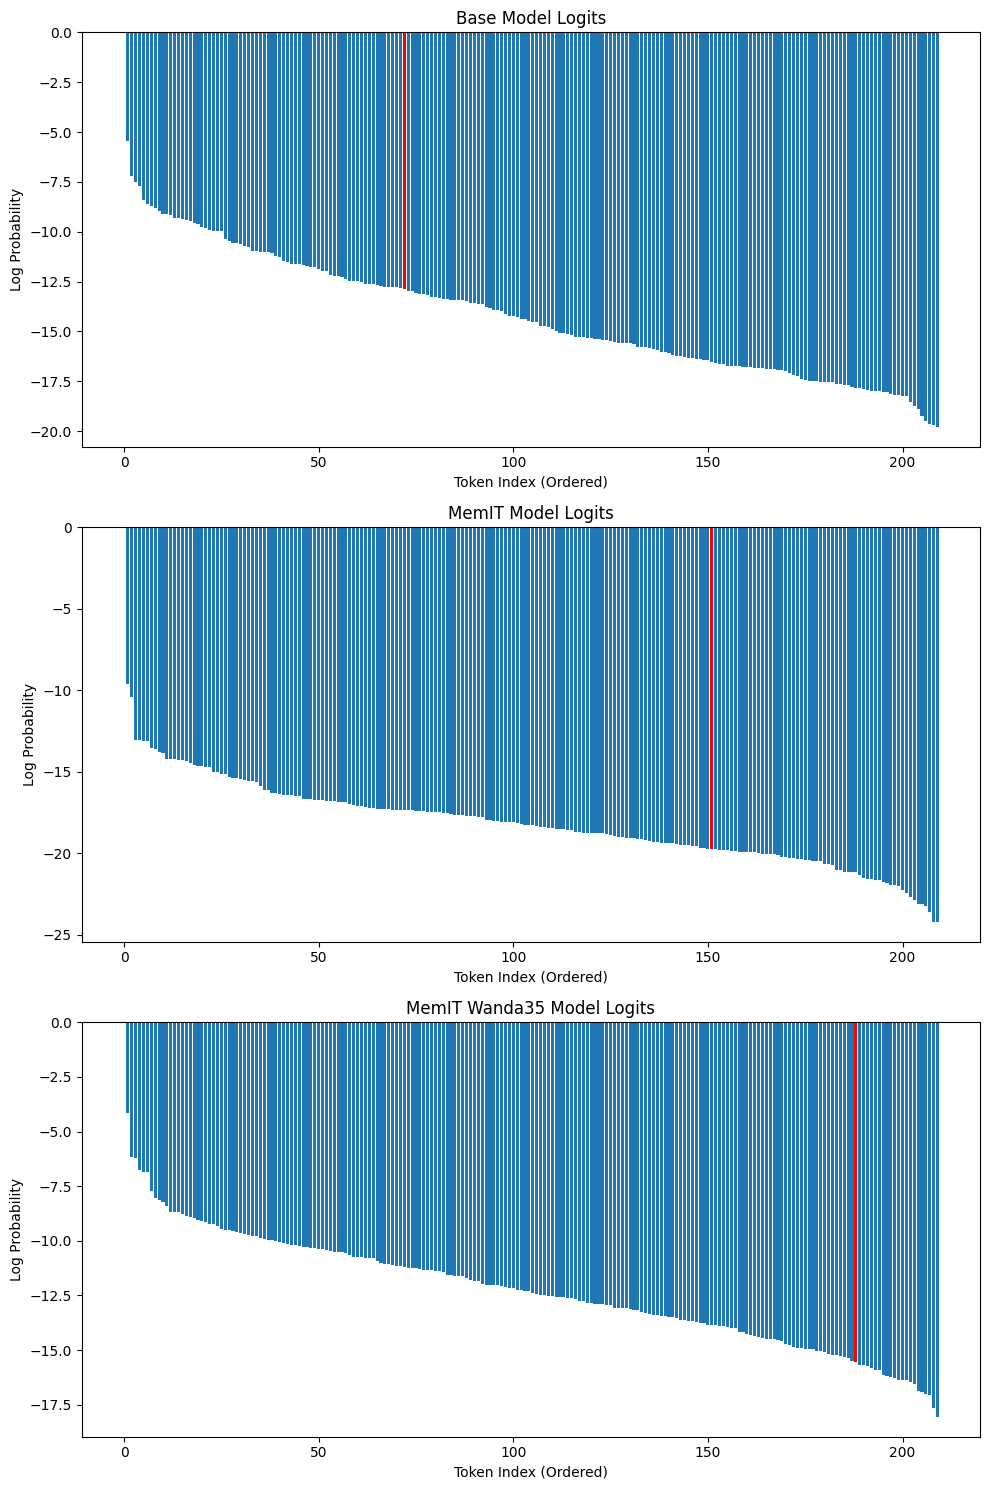

In [42]:
import torch.nn.functional as F

def plot_model_logits(ax, logits, ordered_tokens, target_token_id, title):
    # Convert logits to a tensor and apply softmax to get probabilities
    logits_tensor = torch.from_numpy(logits)
    probabilities = F.softmax(logits_tensor, dim=0)

    # Convert probabilities to log probabilities
    log_probabilities = torch.log(probabilities).numpy()

    # Plot the log probabilities
    ax.bar(range(len(log_probabilities)), log_probabilities)

    # Highlight the target token if it exists in the superset
    if target_token_id in ordered_tokens:
        target_index = np.where(ordered_tokens == target_token_id)[0][0]
        ax.bar(target_index, log_probabilities[target_index], color='red')

    ax.set_title(title)
    ax.set_xlabel('Token Index (Ordered)')
    ax.set_ylabel('Log Probability')

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for the base model
plot_model_logits(axes[0], top_logits_base, ordered_tokens_base, target_token_id, 'Base Model Logits')

# Plot for the memit model - Repeat the loading and processing as shown previously
plot_model_logits(axes[1], top_logits_memit, ordered_tokens_memit, target_token_id, 'MemIT Model Logits')

# Plot for the memit_wanda35 model - Repeat the loading and processing as shown previously
plot_model_logits(axes[2], top_logits_memit_wanda35, ordered_tokens_memit_wanda35, target_token_id, 'MemIT Wanda35 Model Logits')

plt.tight_layout()
plt.show()
